# Predicting customer churn for a telecom company

In this project, a telecommunications operator wants to learn how to predict customer churn. If it turns out that a user plans to leave, they will be offered promo codes and special conditions. We have personal data about some clients, as well as information about their tariffs and contracts, available for analysis.

### Service Description

The operator provides two main types of services:  

1. Landline phone service. The connection of a telephone apparatus to several lines at once is possible.
2. Internet. The connection can be of two types: via a telephone line (DSL) or a fiber optic cable (Fiber optic).

Also, the following services are available:  

* Internet security: antivirus (DeviceProtection) and blocking of unsafe sites (OnlineSecurity);
* Dedicated tech support line (TechSupport);
* Cloud file storage for data backup (OnlineBackup);
* Streaming TV (StreamingTV) and a movie catalog (StreamingMovies).  

Customers can pay for services every month or sign a contract for 1-2 years. Various payment methods are available, as well as the option to receive an electronic check.

### Data Description

The data consists of files obtained from different sources:

- `contract.csv` — contract information;
- `personal.csv` — client's personal data;
- `internet.csv` — information about internet services;
- `phone.csv` — information about telephony services.

In all files, the customerID column contains the client code.

Contract information is up-to-date as of February 1, 2020.


### Task
1. Conduct an exploratory data analysis to determine the difference in behavior between current users and those who have left;
2. Create a predictive model that will help predict customer churn.

### Work plan
1. [Loading and preprocessing the data;](#00)   


2. [Loading and preprocessing the data;](#01)
    * [Analysis of the behavior of the company's active customers and those who have left;](#02)
    * [Analysis of the dynamics of change in the number of new customers;](#03)
    * [Analysis of the influence of payment methods on the monthly payment;](#04)
    * [Analysis of the influence of the tariff (internet+phone, phone only, internet only) on the monthly payment;](#05)
    * [Exploratory analysis. Conclusion.](#06)        
    
    

3. [Creating a predictive model:](#07)   
    * [Preparing data for prediction;](#08)
    * [Working with features - encoding and scaling features, creating new ones, deleting unnecessary ones;](#09)
    * [Upsampling the data;](#10)
    * [Preparing to create models;](#11)
    * [Preliminary training of models;](#12)
    * [Hyperparameter tuning for the best models;](#13)
    * [Analysis of models, validation of the result on the test sample;](#14)
    * [Checking the result for adequacy.](#15)
4. [Overall Conclusion](#16)

In [1]:
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, roc_auc_score, make_scorer

#regressors
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier, Pool
import xgboost as xgb
from lightgbm import LGBMClassifier

# 1. Loading and preprocessing the data <a class='anchor' id='00'></a>

We have four datasets:

1. contract - information about the contract;
2. personal - client's personal data;
3. internet - information about internet services;
4. phone - information about telephony services.  

Let's load each of them, inspect the data, their types, and count the number of missing values and duplicates.

### Сontract - information about the contract

In [2]:
contract = pd.read_csv('/datasets/final_provider/contract.csv')
contract.head(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [3]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
customerID          7043 non-null object
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


The dataset contains 7043 objects and 8 features:

1. customerID - client id;
2. BeginDate - contract start date;
3. EndDate - end date, if applicable;
4. Type - contract type - monthly payment or payment for a year or two in advance;
5. PaperlessBilling - whether the option to receive electronic bills is enabled;
6. PaymentMethod - payment method;
7. MonthlyCharges - monthly cost of the contract;
8. TotalCharges - total cost of the contract over time.  

There are no missing values in the dataset, but the data is cast to incorrect types.  
The data types of the BeginDate and TotalCharges columns need to be changed.

In [4]:
contract['TotalCharges'] = contract['TotalCharges'].replace(' ', 0)
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'])
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'])

The dataset contains 11 records where TotalCharges = 0. These are new customers who arrived less than a month ago and have not yet received a payment bill.

In [5]:
contract[contract['TotalCharges']== 0]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,0.0
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,0.0
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,0.0
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,0.0
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,0.0
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,0.0
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,0.0
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,0.0
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,0.0
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,0.0


### Personal — client's personal data;

In [6]:
personal = pd.read_csv('/datasets/final_provider/personal.csv')
personal.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [7]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
customerID       7043 non-null object
gender           7043 non-null object
SeniorCitizen    7043 non-null int64
Partner          7043 non-null object
Dependents       7043 non-null object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


The dataset contains 7043 records and 5 features:

1. customerID - client id;
2. gender - client's gender;
3. SeniorCitizen - whether the client is a senior citizen or not;
4. Partner - the meaning of the column is not entirely clear. Most likely - whether the client has a partner;
5. Dependents - the meaning of the column is not entirely clear;  

There are no missing values in the dataset. All columns are of the object type except for SeniorCitizen.  
All these features are categorical

### Internet — information about internet services

In [8]:
internet = pd.read_csv('/datasets/final_provider/internet.csv')
internet.head(5)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [9]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
customerID          5517 non-null object
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
dtypes: object(8)
memory usage: 344.9+ KB


The dataset contains 5517 records and 8 features - type of internet connection and status of additional internet services:

1. customerID - client id;
2. InternetService - type of internet connection (can be of two types: via a phone line (DSL) or fiber optic cable);
3. OnlineSecurity - whether the unsafe site blocking service is activated;
4. OnlineBackup - whether the cloud file storage service for data backup is activated;
5. DeviceProtection - whether the antivirus is activated;
6. TechSupport - whether a dedicated tech support line is activated;
7. StreamingTV - whether streaming television is activated;
8. StreamingMovies - whether a movie catalog is activated.  

There are no missing values in the dataset. All columns are of the object type.  
Considering that the number of records is less than in the 'contract' dataset, it can be inferred that not all clients have an internet connection.

### Phone — information about telephony services.  

In [10]:
phone = pd.read_csv('/datasets/final_provider/phone.csv')
phone.head(5)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


The dataset contains 6361 records and just 2 features:

1. customerID - client id;
2. MultipleLines - whether the service for connecting a telephone device to multiple lines at the same time is activated.  

There are no missing values in the dataset. All columns are of the object type.
Given that the number of records is less than in the 'contract' dataset, it can be inferred that not all clients have a phone line connected.

## Checking datasets for missing values and duplicates

Let's write a function to count missing values and check for duplicates.

In [11]:
def miss_inf(data, name):
    shape_data = data.shape
    miss_data = (data.isnull().sum()/data.shape[0]*100).sort_values(ascending = False).head(10)
    print()
    print(name)
    print()
    print('Number of rows and columns in ' + name + ':', shape_data)
    print()
    print('Proportion of missing values in columns (top-10):')
    print(miss_data)
    print()
    print('Number of duplicates in ' + name + ':', data.duplicated().sum())

In [12]:
print(miss_inf(contract, 'contract'))
print(miss_inf(personal, 'personal'))
print(miss_inf(internet, 'internet'))
print(miss_inf(phone, 'phone'))


contract

Количество строк, столбцов в contract: (7043, 8)

Доля пропущенных значений в столбцах (топ-10):
TotalCharges        0.0
MonthlyCharges      0.0
PaymentMethod       0.0
PaperlessBilling    0.0
Type                0.0
EndDate             0.0
BeginDate           0.0
customerID          0.0
dtype: float64

Количество дубликатов в contract: 0
None

personal

Количество строк, столбцов в personal: (7043, 5)

Доля пропущенных значений в столбцах (топ-10):
Dependents       0.0
Partner          0.0
SeniorCitizen    0.0
gender           0.0
customerID       0.0
dtype: float64

Количество дубликатов в personal: 0
None

internet

Количество строк, столбцов в internet: (5517, 8)

Доля пропущенных значений в столбцах (топ-10):
StreamingMovies     0.0
StreamingTV         0.0
TechSupport         0.0
DeviceProtection    0.0
OnlineBackup        0.0
OnlineSecurity      0.0
InternetService     0.0
customerID          0.0
dtype: float64

Количество дубликатов в internet: 0
None

phone

Количест

There are no missing values or duplicates.

### Converting string data to lowercase.

Let's create a function

In [13]:
def lower_casing(dataframe):
    dataframe.columns = dataframe.columns.str.lower()# converting column names to lowercase
    for i in range (len(dataframe.columns)):
        if dataframe.columns[i] != 'customerid':# don't change the data in the 'customerid' column.
            try:
                dataframe[dataframe.columns[i]] = dataframe[dataframe.columns[i]].str.lower()
            except:
                dataframe[dataframe.columns[i]] = dataframe[dataframe.columns[i]]
    return dataframe

Приведем строковые данные исходных таблиц к нижнему регистру

In [14]:
contract = lower_casing(contract)
personal = lower_casing(personal)
internet = lower_casing(internet)
phone = lower_casing(phone)

***
### Conclusion

We have access to 4 datasets with information on contracts, customers, internet and telephony services connected to each contract.
Each dataset contains a 'customerID' column, which allows us to merge them. There are no missing values or duplicates in the datasets.
The first data dates back to 01.10.2013, and the most recent is from 01.02.2020

***
# 2. Исследовательский анализ данных <a class='anchor' id='01'></a>

Основной целью исследовательского анализа является изучение разницы в поведении активных клиентов компании и ушедших.  
Для этого выделим отдельный столбец 'Status' со статусом клиентов.

***
## Анализ поведения активных клиентов компании и ушедших <a class='anchor' id='02'></a>

In [15]:
contract['status'] = contract['enddate'].apply(lambda x: 'active_client' if x =='no' else 'gone_client')
# contract.loc[contract['enddate'] == 'no', 'status'] = 'active_client'
# contract.loc[contract['enddate'] != 'no', 'status'] = 'gone_client'
contract.head(5)

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,status
0,7590-VHVEG,2020-01-01,no,month-to-month,yes,electronic check,29.85,29.85,active_client
1,5575-GNVDE,2017-04-01,no,one year,no,mailed check,56.95,1889.50,active_client
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,month-to-month,yes,mailed check,53.85,108.15,gone_client
3,7795-CFOCW,2016-05-01,no,one year,no,bank transfer (automatic),42.30,1840.75,active_client
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,month-to-month,yes,electronic check,70.70,151.65,gone_client


Построим график распределения величин ежемесячных платежей всех действующих клиентов и тех, кто ушёл.

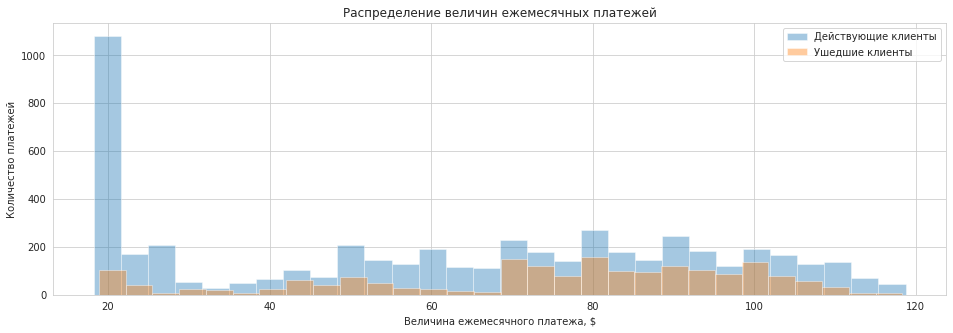

In [16]:
sns.set_style('whitegrid')
plt.figure(figsize=(16, 5))
sns.distplot(contract['monthlycharges'][contract['status']=='active_client'], kde=False, bins=30, label='Действующие клиенты')
sns.distplot(contract['monthlycharges'][contract['status']=='gone_client'], kde=False, bins=30, label='Ушедшие клиенты')
plt.title("Распределение величин ежемесячных платежей")
plt.xlabel('Величина ежемесячного платежа, $')
plt.ylabel('Количество платежей')
plt.legend()
plt.show()

Из получившегося графика можно сделать вывод, что клиенты с небольшой величиной месячного платежа верны компании и не уходят от нее.  
Проверим это предположение, сравнив статистики этих двух групп клиентов.

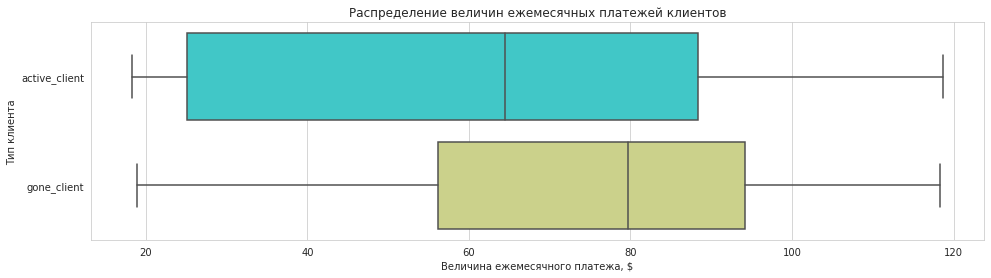

status,active_client,gone_client
count,5174.000000,1869.000000
mean,61.265124,74.441332
std,31.092648,24.666053
min,18.250000,18.850000
25%,25.100000,56.150000
50%,64.425000,79.650000
75%,88.400000,94.200000
max,118.750000,118.350000


In [17]:
sns.set_style('whitegrid')
plt.figure(figsize=(16, 4))
sns.boxplot(x="monthlycharges", y="status", data=contract, palette='rainbow', orient='h')
plt.title("Распределение величин ежемесячных платежей клиентов")
plt.xlabel('Величина ежемесячного платежа, $')
plt.ylabel('Тип клиента')
plt.show()

# вывод числовых характеристи ежемесячных выплат по действующим и недействующим пользователям
contract.groupby('status')['monthlycharges'].describe().transpose()

Диаграмма размаха также показывает, что у действующих клиентов медианные значения, 25% и 75% квартили ниже, чем у ушедших.

Объединим все датасеты в один для того, чтобы понять, какими услугами пользовались клиенты и добавим новые признаки:
* Internet_client - показывает пользовался ли клиент услугами интернета;
* Phone_client - показывает пользовался ли клиент услугами телефонной связи;
* Tariff - показывает комбинацию тарифов клиента.

In [18]:
#Соединим таблицы методом merge
data = contract.merge(personal, on = 'customerid', how = 'left')
data = data.merge(internet, on = 'customerid', how = 'left')
data = data.merge(phone, on = 'customerid', how = 'left')

#Создадим новые признаки
data.loc[data['internetservice'].isna() == False, 'internet_client'] = 'yes'
data.loc[data['internetservice'].isna() == True, 'internet_client'] = 'no'
data.loc[data['multiplelines'].isna() == True, 'phone_client'] = 'no'
data.loc[data['multiplelines'].isna() == False, 'phone_client'] = 'yes'
data.loc[(data['internet_client']== 'yes') & (data['phone_client']== 'yes'), 'tariff'] = 'internet + phone'
data.loc[(data['internet_client']== 'yes') & (data['phone_client']== 'no'), 'tariff'] = 'internet'
data.loc[(data['internet_client']== 'no') & (data['phone_client']== 'yes'), 'tariff'] = 'phone'
data.head(5)

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,status,gender,...,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines,internet_client,phone_client,tariff
0,7590-VHVEG,2020-01-01,no,month-to-month,yes,electronic check,29.85,29.85,active_client,female,...,no,yes,no,no,no,no,NaN,yes,no,internet
1,5575-GNVDE,2017-04-01,no,one year,no,mailed check,56.95,1889.50,active_client,male,...,yes,no,yes,no,no,no,no,yes,yes,internet + phone
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,month-to-month,yes,mailed check,53.85,108.15,gone_client,male,...,yes,yes,no,no,no,no,no,yes,yes,internet + phone
3,7795-CFOCW,2016-05-01,no,one year,no,bank transfer (automatic),42.30,1840.75,active_client,male,...,yes,no,yes,yes,no,no,NaN,yes,no,internet
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,month-to-month,yes,electronic check,70.70,151.65,gone_client,female,...,no,no,no,no,no,no,no,yes,yes,internet + phone


Сравним поведение действующих и ушедших клиентов. Для каждой группы построим два графика, изображающих долю пользователей телефонной связи и долю интернет-пользователей.

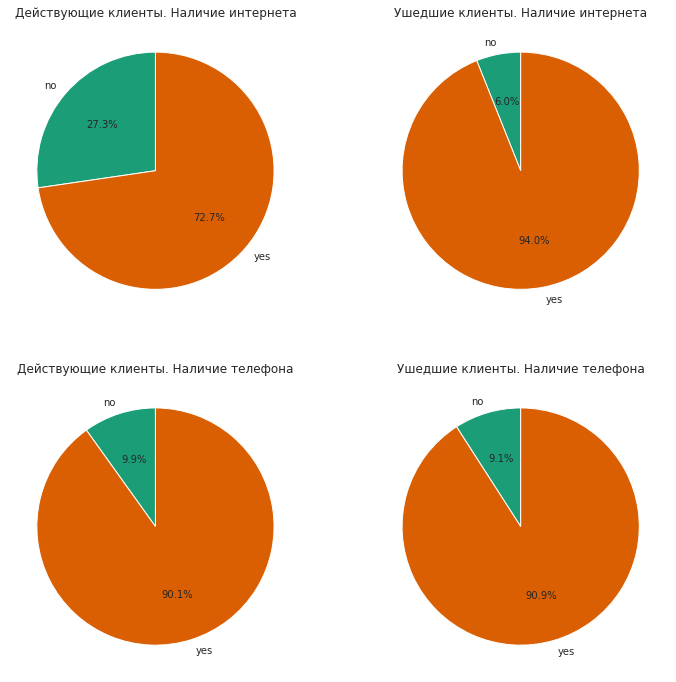

In [19]:
# Подготовка данных
df_active = data[data['status']=='active_client'].groupby('internet_client').size().reset_index(name='counts')
df_gone = data[data['status']=='gone_client'].groupby('internet_client').size().reset_index(name='counts')
df_active_phone = data[data['status']=='active_client'].groupby('phone_client').size().reset_index(name='counts')
df_gone_phone = data[data['status']=='gone_client'].groupby('phone_client').size().reset_index(name='counts')

# Создание графика
fig, axes = plt.subplots(2, 2, figsize = (12, 12))

labels = df_active['internet_client']
sizes = df_active['counts']
explode = (0, 0)  
axes[0, 0].pie(sizes, explode=explode,  labels = labels, autopct='%1.1f%%', startangle=90, colors=plt.cm.Dark2.colors)
axes[0, 0].set_title('Действующие клиенты. Наличие интернета')

labels1 = df_gone['internet_client']
sizes = df_gone['counts']
axes[0, 1].pie(sizes, explode=explode,  labels = labels1, autopct='%1.1f%%', startangle=90, colors=plt.cm.Dark2.colors)
axes[0, 1].set_title('Ушедшие клиенты. Наличие интернета')

labels2 = df_active_phone['phone_client']
sizes = df_active_phone['counts']
explode = (0, 0)  
axes[1, 0].pie(sizes, explode=explode,  labels = labels2, autopct='%1.1f%%', startangle=90, colors=plt.cm.Dark2.colors)
axes[1, 0].set_title('Действующие клиенты. Наличие телефона')

labels3 = df_gone_phone['phone_client']
sizes = df_gone_phone['counts']
axes[1, 1].pie(sizes, explode=explode,  labels = labels3, autopct='%1.1f%%', startangle=90, colors=plt.cm.Dark2.colors)
axes[1, 1].set_title('Ушедшие клиенты. Наличие телефона')

plt.show()

Видим на графиках, что доля пользователей телефонной связи не изменяется в группе ушедших и действующих клиентов.  
При этом доля пользователей интернета среди ушедших пользователей намного больше, чем среди действующих.  

Из этого можно сделать вывод о том, что качество услуг телефонной связи устраивает клиентов, а основной причиной ухода является качество или цена интернет-услуг.

***
### Вывод

При сравнении активных клиентов компании и ушедших были сделаны следующие выводы:
* Клиенты с небольшой величиной месячного платежа верны компании и не уходят от нее;
* Диаграмма размаха показала, что у действующих клиентов медианные значения месячного платежа, 25% и 75% квартили ниже, чем у ушедших;
* Доля пользователей телефонной связи не изменяется в группе ушедших и действующих клиентов;
* Доля пользователей интернета среди ушедших пользователей намного больше, чем среди действующих.  

Из этих замечаний можно сделать вывод о том, что качество услуг телефонной связи устраивает клиентов, а основной причиной ухода является качество или цена интернет-услуг.

***
## Анализ динамики изменения количества новых клиентов <a class='anchor' id='02'></a>

Посмотрим на динамику подключения новых клиентов

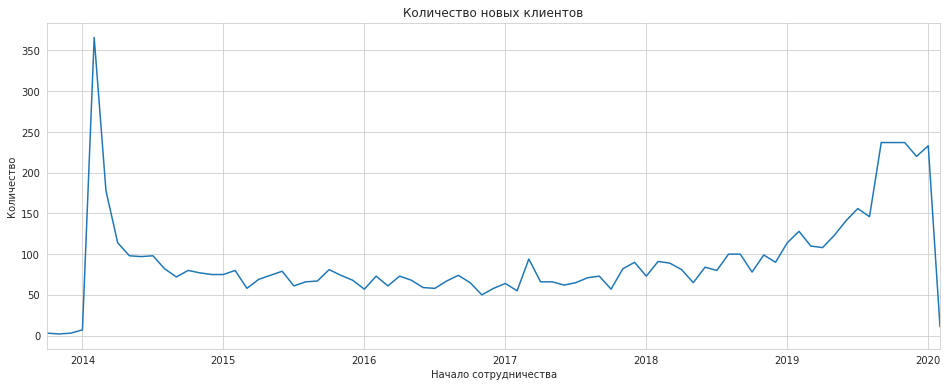

In [20]:
data.groupby('begindate')['totalcharges'].count().plot(figsize = (16, 6))
plt.title("Количество новых клиентов")
plt.xlabel('Начало сотрудничества')
plt.ylabel('Количество')
plt.show()

Видим, что данные у нас есть в основном с января 2014 года по январь 2020 года, при этом продажи в января 2020 года очень сильно упали, даже складывается впечатление, что не у нас не полная база данных за этот период.

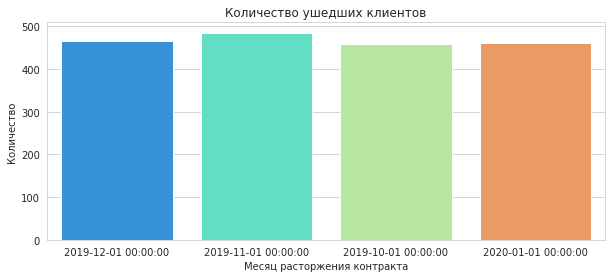

In [21]:
sns.set_style('whitegrid')
plt.figure(figsize=(10, 4))
sns.countplot(x='enddate', data=data[data['enddate'] != 'no'], palette='rainbow')
plt.title("Количество ушедших клиентов")
plt.xlabel('Месяц расторжения контракта')
plt.ylabel('Количество')
plt.show()

Уходить клиенты начали только с октября 2019 года и продолжают уходить примерно в одинаковом количестве по текущий момент.

***
## Анализ влияния типа контракта на общие расходы клиента <a class='anchor' id='03'></a>

Проанализируем распределение типов контрактов на общие расходы клиента за время сотрудничества с компанией.

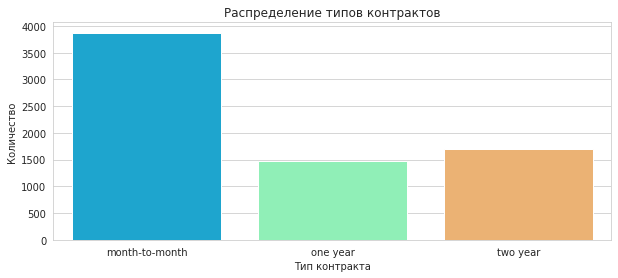

In [22]:
sns.set_style('whitegrid')
plt.figure(figsize=(10, 4))
sns.countplot(x='type', data=contract, palette='rainbow')
plt.title("Распределение типов контрактов")
plt.xlabel('Тип контракта')
plt.ylabel('Количество')
plt.show()

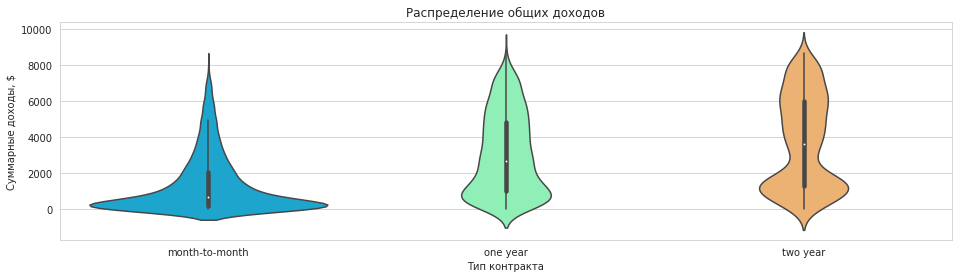

In [23]:
sns.set_style('whitegrid')
plt.figure(figsize=(16, 4))
sns.violinplot(x="type", y="totalcharges", data=contract, palette='rainbow')
plt.title("Распределение общих доходов")
plt.xlabel('Тип контракта')
plt.ylabel('Суммарные доходы, $')
plt.show()

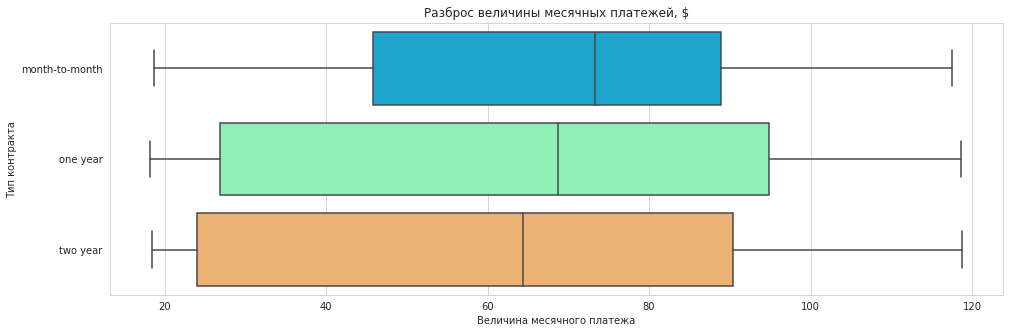

In [24]:
sns.set_style('whitegrid')
plt.figure(figsize=(16, 5))
sns.boxplot(x='monthlycharges', y='type', data=data, palette='rainbow', orient='h')
plt.title("Разброс величины месячных платежей, $")
plt.xlabel('Величина месячного платежа')
plt.ylabel('Тип контракта')
plt.show()

Из графика видно, что наибольшую суммарную прибыль приносят клиенты с долгосрочными контрактами - на один-два года.  
При этом средние месячные платежи выше у краткосрочных контрактов.  

Можно предположить, что клиенты с тарифом помесячной оплаты чаще уходят от компании. Проверим это.

In [25]:
def pivot(data, column):
    tariff_piv = data.pivot_table(index=column, columns = 'status', values = 'customerid', aggfunc = 'count')
    tariff_piv['ratio'] = tariff_piv['gone_client'] / (tariff_piv['gone_client'] + tariff_piv['active_client'])
    return tariff_piv

In [26]:
pivot(data, data['type'])

status,active_client,gone_client,ratio
type,,,
month-to-month,2220,1655,0.427097
one year,1307,166,0.112695
two year,1647,48,0.028319


Так и есть. Доля ушедших клиентов намного выше среди помесячных контрактов и достигает 42%.

***
## Анализ влияния способов оплаты на месячный платеж <a class='anchor' id='04'></a>

Рассмотрим распределение типов контрактов на общие расходы клиента за время сотрудничества с компанией.

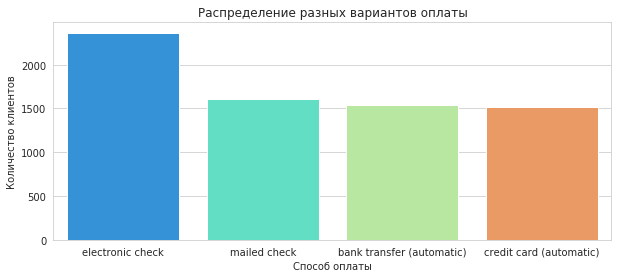

In [27]:
sns.set_style('whitegrid')
plt.figure(figsize=(10, 4))
sns.countplot(x='paymentmethod', data=contract, palette='rainbow')
plt.title("Распределение разных вариантов оплаты")
plt.xlabel('Способ оплаты')
plt.ylabel('Количество клиентов')
plt.show()

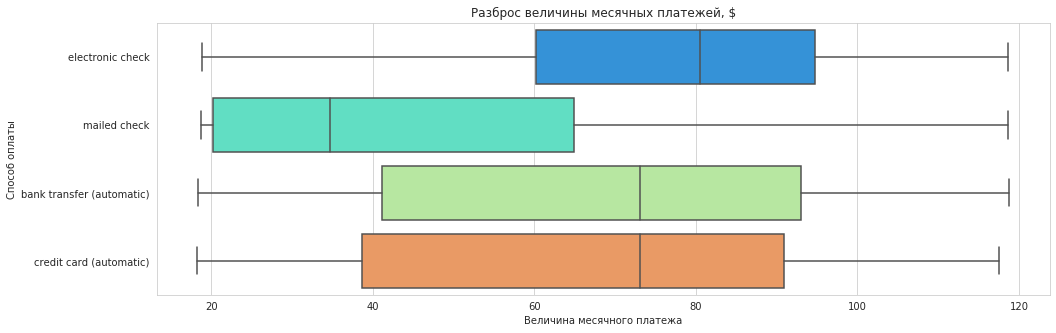

In [28]:
sns.set_style('whitegrid')
plt.figure(figsize=(16, 5))
sns.boxplot(x='monthlycharges', y='paymentmethod', data=data, palette='rainbow', orient='h')
plt.title("Разброс величины месячных платежей, $")
plt.xlabel('Величина месячного платежа')
plt.ylabel('Способ оплаты')
plt.show()

Наибольший месячная стоимость у электронного чека, который высылается на почту и клиент каждый раз его самостоятельно оплачивает.  
Наименьшая стоимость у чеков, высылаемых по почте, скорее всего таким образом оплачиваются телефонные услуги некоторыми слоями населения.  
Автоматические платежи чуть меньше по размеру, чем электронные чеки.  

Проверим, насколько велика разница в количестве ушедших клиентов. 

In [29]:
pivot(data, data['paymentmethod'])

status,active_client,gone_client,ratio
paymentmethod,,,
bank transfer (automatic),1286,258,0.167098
credit card (automatic),1290,232,0.152431
electronic check,1294,1071,0.452854
mailed check,1304,308,0.191067


Видно, что количество ушедших клиентов намного больше у типа оплаты Electronic check, чем у остальных.  
Возможно проблема в уходе кроется в неудобной системе оплаты или ошибках в форме оплаты.

***
## Анализ влияния тарифа (интернет+телефон, только телефон, только интернет) на месячный платеж <a class='anchor' id='05'></a>

Рассмотрим распределение велечины ежемесячной оплаты в зависимости от тарифа (интернет+телефон, только телефон, только интернет). 

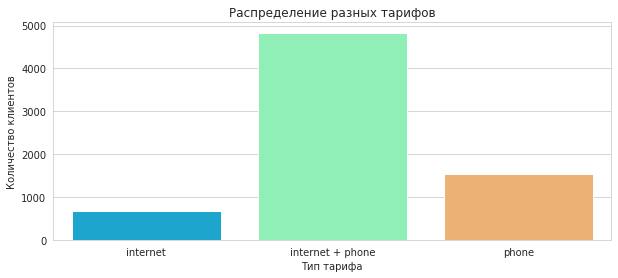

In [30]:
sns.set_style('whitegrid')
plt.figure(figsize=(10, 4))
sns.countplot(x='tariff', data=data, palette='rainbow')
plt.title("Распределение разных тарифов")
plt.xlabel('Тип тарифа')
plt.ylabel('Количество клиентов')
plt.show()

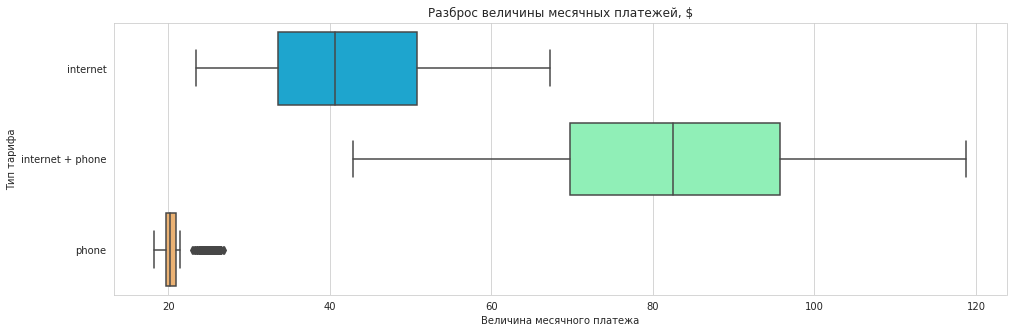

In [31]:
sns.set_style('whitegrid')
plt.figure(figsize=(16, 5))
sns.boxplot(x='monthlycharges', y='tariff', data=data, palette='rainbow', orient='h')
plt.title("Разброс величины месячных платежей, $")
plt.xlabel('Величина месячного платежа')
plt.ylabel('Тип тарифа')
plt.show()

Разброс величин ежемесячного платежа очень большой. Наибольший платеж у клиентов, которые пользуются и интернетом, и телефоном.  
Так же видно, что таких клиентов больше всего.


In [32]:
pivot(data, data['phone_client'])

status,active_client,gone_client,ratio
phone_client,,,
no,512,170,0.249267
yes,4662,1699,0.267096


In [33]:
pivot(data, data['internet_client'])

status,active_client,gone_client,ratio
internet_client,,,
no,1413,113,0.074050
yes,3761,1756,0.318289


Видим, что данные также подтверждают наши более ранние замечания о том, что клиенты, пользующиеся только телефоном не прекращают сотрудничество, а основной причиной ухода является качество или цена интернет-услуг.

***
## Исследовательский анализ. Вывод. <a class='anchor' id='06'></a>

Предварительно можно делать следующие выводы о том, что доля ушедших пользователей намного выше:
* У пользователей интернет-услуг, чем у пользователей услуг телефонной связи;
* У пользователей с ежемесячной оплатой, чем с долгосроными контрактами;
* У пользователей без автоматического ежемесячного списания оплаты.

Средний месячный чек выше у пользователей на тарифе Интернет+Телефон, с ежемесячным платежом и электронным чеком.  
Однако общая прибыль выше у долгосрочных контрактов с автоматическим списанием оплаты.  

С большой долей вероятности можно сказать, что интернет пользователи с помесячной ручной оплатой более привержены к уходу от сотрудничества с нашей компанией. На это могут виять, как новые конкруенты, так и проблемы с формой или алгоритмом оплаты на сайте.
***
*Однако все данные предположения необходимо проверять статистически в связи с тем, что у нас есть только частичная выборка.*

***
# 3. Создание предиктивной модели <a class='anchor' id='07'></a>

В данном проекте нам необходимо решить задачу бинарной классификации.  
Основной метрикой, которую мы будем оптимизировать будет являться ROC-AUC. Минимально удовлетворяющий результат этой метрики -0.75, в идеале получить результат близкий к 0.85 и выше.  
Также, по требованию заказчика, необходимо выводить результат метрики Accuracy, но ее можно не оптимизировать.  

План работ на данном этапе следующий:
    * Подготовка данных для прогнозирования;
    * Работа с признаками - перевод категориальных признаков в количественные, создание новых, удаление ненужных;
    * Upsampling данных и разбивка данных на выборки;
    * Предварительное обучение моделей;
    * Анализ результатов и подбор параметров у лучших моделей;
    * Выбор наилучшей модели, валидация результата на тестовой выборке.

## Подготовка данных для прогнозирования <a class='anchor' id='08'></a>

Основной задачей при подготовке имеющихся данных на данном этапе будет заполнение пропусков, которые появились после объединения таблиц, преобразование даты из столбца enddate в формат datetime.

Для начала проверим, в каких столбцах появились пропуски.

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
customerid          7043 non-null object
begindate           7043 non-null datetime64[ns]
enddate             7043 non-null object
type                7043 non-null object
paperlessbilling    7043 non-null object
paymentmethod       7043 non-null object
monthlycharges      7043 non-null float64
totalcharges        7043 non-null float64
status              7043 non-null object
gender              7043 non-null object
seniorcitizen       7043 non-null int64
partner             7043 non-null object
dependents          7043 non-null object
internetservice     5517 non-null object
onlinesecurity      5517 non-null object
onlinebackup        5517 non-null object
deviceprotection    5517 non-null object
techsupport         5517 non-null object
streamingtv         5517 non-null object
streamingmovies     5517 non-null object
multiplelines       6361 non-null object
internet_client     704

Как и ожидалось, они появились в столбцах, связанных с наличием подключения раличных интернет и телефонных услуг в связи с тем, что не у всех клиентов подключен интернет или телефон.  
Заменим эти пропуски текстовыми значениями - 'no_internet' и 'no_phone'.

In [35]:
data['multiplelines'] = data['multiplelines'].fillna('no_pnone')
data = data.fillna('no_internet')

Создадим новый столбец 'enddate_true', в которй перенесем имеющиеся даты из столбца enddate, а у действующих клиентов заменим значения no на дату выгрузки батасета - '2020-02-01'.

In [36]:
data['enddate_true'] = data['enddate'].apply(lambda x: '2020-02-01' if x =='no' else x)

Проверим корректность замены

In [37]:
data['enddate_true'].value_counts()

2020-02-01             5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: enddate_true, dtype: int64

Переведем данные столбца в формат datetime.

In [38]:
data['enddate_true'] = pd.to_datetime(data['enddate_true'])

***
## Работа с признаками <a class='anchor' id='09'></a>

Для обучения модели проведем работу по подготовке признаков:
* Создадим целевой признак;
* Добавим новые обучающие признаки;
* Удалим ненужные обучающие признаки;
* Проведем прямое кодирование и масштабирование признаков.

### Создание целевого признака

Создадим целевой признак - если у признака enddate значение 'no', то ставим 0, т.е. клиент остался, иначе 1, т.е. клиент ушел.

In [39]:
data['target'] = data['enddate'].apply(lambda x: 0 if x =='no' else 1)

### Добавление новых обучающих признаков

Добавим обучающий признак - Время жизни абонента (clv). Для этого вычтем из значений столбца enddate_true столбец begindate.

In [40]:
data['clv'] = (data['enddate_true'] - data['begindate']).dt.days

Проверим рспределение значений, чтобы понять, есть ли утечка целевого признака

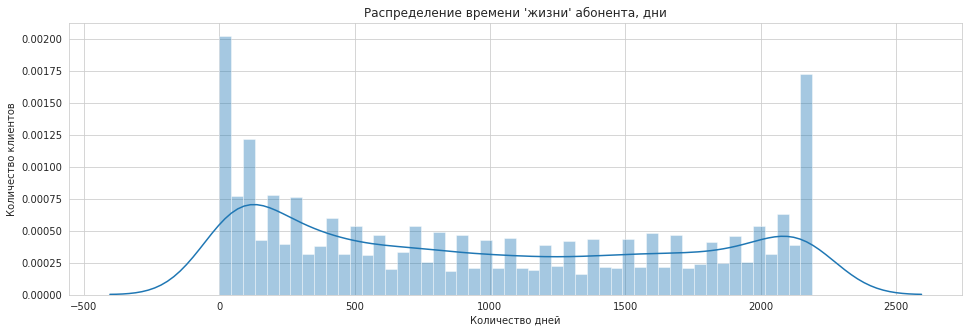

31      431
2191    362
30      182
92      169
2163    164
       ... 
1552      2
2068      2
1369      2
1917      1
2161      1
Name: clv, Length: 156, dtype: int64

In [41]:
sns.set_style('whitegrid')
plt.figure(figsize=(16, 5))
sns.distplot(data['clv'], bins=50)
plt.title("Распределение времени 'жизни' абонента, дни")
plt.xlabel('Количество дней')
plt.ylabel('Количество клиентов')
plt.show() 

data['clv'].value_counts()

Распределение не является нормальным, но и не повторяет количество оставшихся клиентов. Будем считать, что этот признак не является утечкой целевого признака.

### Удаление ненужных обучающих признаков

**Проверим, какие признаки важны для обучения моделей.**  
Для этого разобъем датасет на выборки и удалим точно лишние признаки - customerid, столбцы с датами и созданные для анализа столбцы.  
После этого с помощью метода feature_importances_ посмотрим какие признаки наиболее важны для моделей. В качестве модели возьмем Случайный лес.

In [42]:
features_ = data.drop(['customerid', 'begindate', 'enddate', 'status', 'internet_client', 
                       'phone_client', 'tariff', 'enddate_true', 'target'], axis=1)
target_ = data['target']
features_ = pd.get_dummies(features_, drop_first=True)

X_train, X_valid, y_train, y_valid = train_test_split(
    features_, target_, test_size=0.4, random_state=12345
)

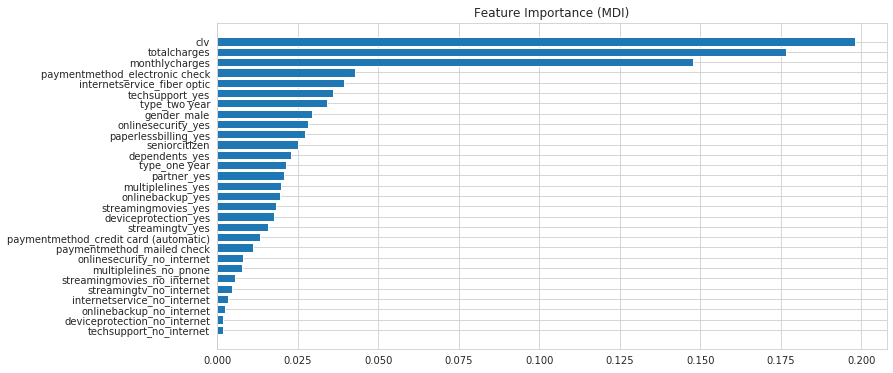

In [87]:
#обучим базовую модель и посчитаем feature_importance
rfc1 = RandomForestClassifier(random_state=42)
rfc1.fit(X_train, y_train)
feature_importance = rfc1.feature_importances_

# построим график
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))

plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(features_.columns)[sorted_idx])
plt.title('Feature Importance (MDI)')

plt.show()

Три наиболее важных признака clv, totalcharges и monthlycharges.  

Признак totalcharges находится в середине списка признаков по важности, в первый раз удалил его, предположив, что он может сильно коррелировать с monthlycharges. Проверим, так ли это на самом деле.

In [44]:
corr = data['monthlycharges'].corr(data['totalcharges'])
print('Корреляция между monthlycharges и totalcharges = {:.2f}'.format(corr))

Корреляция между monthlycharges и totalcharges = 0.65


Корреляция между признаками 0.65. Это много, но попробуем убрать totalcharges.  

В результате тестирования двух варинатов лучший результат показала модель без totalcharges.

**Удалим ненужные признаки из основного датасета.**

In [45]:
data_new = data.drop(['customerid', 'begindate', 'enddate', 'paperlessbilling', 'totalcharges', 
                      'status', 'internet_client', 'phone_client', 'tariff', 'enddate_true'], axis=1)

In [46]:
data_new.head(5)

,type,paymentmethod,monthlycharges,gender,seniorcitizen,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines,target,clv
0,month-to-month,electronic check,29.85,female,0,yes,no,dsl,no,yes,no,no,no,no,no_pnone,0,31
1,one year,mailed check,56.95,male,0,no,no,dsl,yes,no,yes,no,no,no,no,0,1036
2,month-to-month,mailed check,53.85,male,0,no,no,dsl,yes,yes,no,no,no,no,no,1,61
3,one year,bank transfer (automatic),42.30,male,0,no,no,dsl,yes,no,yes,yes,no,no,no_pnone,0,1371
4,month-to-month,electronic check,70.70,female,0,no,no,fiber optic,no,no,no,no,no,no,no,1,61


### Преобразование категориальных признаков в численные

Переведем категориальных признаков в численные с помощью метода прямого кодирования

In [47]:
data_new_ohe = pd.get_dummies(data_new, drop_first=True)
data_new_ohe.head()

,monthlycharges,seniorcitizen,target,clv,type_one year,type_two year,paymentmethod_credit card (automatic),paymentmethod_electronic check,paymentmethod_mailed check,gender_male,...,deviceprotection_no_internet,deviceprotection_yes,techsupport_no_internet,techsupport_yes,streamingtv_no_internet,streamingtv_yes,streamingmovies_no_internet,streamingmovies_yes,multiplelines_no_pnone,multiplelines_yes
0,29.85,0,0,31,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1,56.95,0,0,1036,1,0,0,0,1,1,...,0,1,0,0,0,0,0,0,0,0
2,53.85,0,1,61,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,42.30,0,0,1371,1,0,0,0,0,1,...,0,1,0,1,0,0,0,0,1,0
4,70.70,0,1,61,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


### Масштабирование количественных признаков

Теперь проведем масштабирование данных в оставшихся численных столбцах, не трогая целевой столбец target.  
Перед проведением масштабирования разделим данные на три выборки - обучающую, валидационную, тестовую в соотношении 3/1/1.

In [48]:
features = data_new_ohe.drop('target', axis=1)
target = data_new_ohe['target']

features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.4, random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid, test_size=0.5, random_state=12345)

print('Размер обучающей выборки:', features_train.shape)
print('Размер валидационной выборки:', features_valid.shape)
print('Размер тестовой выборки:', features_test.shape)

Размер обучающей выборки: (4225, 27)
Размер валидационной выборки: (1409, 27)
Размер тестовой выборки: (1409, 27)


Теперь проведем масштабирование количественных признаков с помощью метода Стандартизация.
Стандартизация подразумевает такую предобработку данных, после которой каждый признак имеет среднее 0 и дисперсию 1. Создадим функцию стандартизации и проверим распрделение после проведения масштабирования.

In [49]:
numeric = ['monthlycharges', 'clv']

scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

features_train[['monthlycharges', 'clv']].describe().round(4)

,monthlycharges,clv
count,4225.0000,4225.0000
mean,-0.0000,-0.0000
std,1.0001,1.0001
min,-1.5407,-1.3439
25%,-0.9695,-0.9729
50%,0.1829,-0.1154
75%,0.8451,0.9491
max,1.7872,1.6009


Масштабирование прошло успешно.

***
## Upsampling данных <a class='anchor' id='10'></a>

Произведем балансировку классов путем upsampling данных, для этого предварительно посмотрим соотношение классов в полной выборке.

In [50]:
data_new_ohe['target'].value_counts(normalize=True)

0    0.73463
1    0.26537
Name: target, dtype: float64

Преобразование проведем в несколько этапов:

* Разделим обучающую выборку на отрицательные и положительные объекты;
* Скопируем несколько раз положительные объекты -в нашем случае увеличиваем выборку положительных объектов в 3 раза;
* С учётом полученных данных создадим новую обучающую выборку;
* Перемешаем данные.

In [51]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 3)

Посмотрим размеры новых таблиц и изучим новый баланс классов.

In [52]:
print('Размеры таблицы features_upsampled:', features_upsampled.shape)
print('Размеры таблицы target_upsampled:',target_upsampled.shape)
print()
print(target_upsampled.value_counts(normalize=True))

Размеры таблицы features_upsampled: (6427, 27)
Размеры таблицы target_upsampled: (6427,)

1    0.513926
0    0.486074
Name: target, dtype: float64


Классы сбалансированны, можем начинать обучать модели.

***
# Обучение моделей <a class='anchor' id='11'></a>

В данном проекте применим несколько стандартных моделей типа логистическиой регрессии и случайного леса и модели, основанные на градиентном бустинге.  

Для начала создадим все функции, которые нам потребуются поздее.

### Подготовка к созданию моделей.

Зафиксируем значение random_state

In [53]:
RND_ST = 42

Построим функцию обучения моделей без подбора параметров

In [54]:
def ml_models(models, ft, tt, fv, tv):
    model = models
    model.fit(ft, tt)
    predictions_valid = model.predict(fv)
    probabilities_valid = model.predict_proba(fv)
    print('AUC-ROC = {:.2f}'.format(roc_auc_score(tv, probabilities_valid[:,1])))    
    print('accuracy_score = {:.2f}'.format(accuracy_score(tv, predictions_valid)))

Так как метрика roc_auc_score является метрической функцией, создадим scorer, необходимых для gridsearch

In [55]:
roc_auc = make_scorer(roc_auc_score, greater_is_better=True, needs_proba=True)

Создадим функцию для применения GridSearchCV

In [56]:
def gridsearchcv(model, grid, features, target):

    CV = GridSearchCV(estimator = model, param_grid = grid, cv = 5, scoring = roc_auc)
    CV.fit(features, target)
    
    print('AUC-ROC = {:.2f}'.format(CV.best_score_))
    print(CV.best_params_)

В случае, если gridsearch будет занимать много времени, то воспользуемся RandomizedSearchCV

In [57]:
def rand_search(model, grid, features, target):
    
    search = RandomizedSearchCV(model, grid, cv=5, scoring=roc_auc, n_jobs=-1)
    search.fit(features, target)
    
    print('AUC-ROC = {:.2f}'.format(search.best_score_))
    print(search.best_params_)

Для валидации результатов моделей создадим функцию, без обучения моделей.

In [58]:
def auc_roc_val(model, fv, tv, name):
    
    predictions_valid = model.predict(fv)
    probabilities_valid = model.predict_proba(fv)
    print(name + ' AUC-ROC = {:.2f}'.format(roc_auc_score(tv, probabilities_valid[:,1])))    
    print(name + ' accuracy_score = {:.2f}'.format(accuracy_score(tv, predictions_valid)))

***
## Первичное обучение моделей без подбора гиперпараметров. <a class='anchor' id='12'></a>

Обучим модели без подбора параметров и посмотрим получившиеся результаты

**Логистическая регрессия**

In [59]:
ml_models(LogisticRegression(random_state=RND_ST), features_upsampled, target_upsampled, features_valid, target_valid)

AUC-ROC = 0.85
accuracy_score = 0.75


**Дерево решений**

In [60]:
ml_models(DecisionTreeClassifier(random_state=RND_ST), features_upsampled, target_upsampled, features_valid, target_valid)

AUC-ROC = 0.70
accuracy_score = 0.78


**Случайный лес**

In [61]:
ml_models(RandomForestClassifier(random_state=RND_ST), features_upsampled, target_upsampled, features_valid, target_valid)

AUC-ROC = 0.83
accuracy_score = 0.80


**Градиентный бустинг**

In [62]:
ml_models(GradientBoostingClassifier(random_state=RND_ST), features_upsampled, target_upsampled, features_valid, target_valid)

AUC-ROC = 0.88
accuracy_score = 0.79


**LGBMClassifier**

In [63]:
ml_models(LGBMClassifier(random_state=RND_ST), features_upsampled, target_upsampled, features_valid, target_valid)

AUC-ROC = 0.90
accuracy_score = 0.82


**CatBoostClassifier**

In [64]:
ml_models(CatBoostClassifier(random_state=RND_ST, verbose = 0), features_upsampled, target_upsampled, features_valid, target_valid)

AUC-ROC = 0.91
accuracy_score = 0.84


Наилучшие результаты показали модели бустинга и логистическая регрессия.  

На следующем шаге подберем гиперпараметры лучших моделей и модели случайный лес.

***
## Подбор гиперпараметров <a class='anchor' id='13'></a>

**Подберем параметры для модели Случайный лес**

In [65]:
rfc = RandomForestClassifier(random_state=RND_ST)

rfc_params = dict(max_depth=range(2, 15, 2), 
                 max_features=range(2, 15, 2),
                 n_estimators=range(25, 200, 25))

In [66]:
rand_search(rfc, rfc_params, features_upsampled, target_upsampled)

AUC-ROC = 0.95
{'n_estimators': 75, 'max_features': 2, 'max_depth': 12}


Результат AUC-ROC равен 0.97. Похоже на переобучение.

Проведем проверку работы модели на валидационной выборке

In [67]:
rfc = RandomForestClassifier(random_state=RND_ST, n_estimators = 150, max_features = 2, max_depth = 14)
rfc.fit(features_upsampled, target_upsampled)

auc_roc_val(rfc, features_valid, target_valid, 'Результат на валидационной выборке:')

Результат на валидационной выборке: AUC-ROC = 0.84
Результат на валидационной выборке: accuracy_score = 0.79


**Подберем параметры для модели GradientBoostingClassifier**

In [68]:
gbr = GradientBoostingClassifier(random_state=RND_ST)

gbr_params = dict(n_estimators=range(50, 200, 25),
                  max_depth=[2,3,4], 
                  learning_rate=[0.1,0.5,1],
                 )

In [69]:
gridsearchcv(gbr, gbr_params, features_upsampled, target_upsampled)

AUC-ROC = 0.98
{'learning_rate': 0.5, 'max_depth': 4, 'n_estimators': 175}


Проведем проверку работы модели на валидационной выборке

In [70]:
gbr = GradientBoostingClassifier(random_state=RND_ST, learning_rate = 0.5, max_depth = 4, n_estimators = 175)
gbr.fit(features_upsampled, target_upsampled)

auc_roc_val(gbr, features_valid, target_valid, 'Результат на валидационной выборке:')

Результат на валидационной выборке: AUC-ROC = 0.92
Результат на валидационной выборке: accuracy_score = 0.86


**Подберем параметры для модели LGBMClassifier**

In [71]:
LGBM = LGBMClassifier()
LGBM_params = dict(n_estimators = [175, 200],
                   max_depth = [7, 10],
                   verbose = [0] 
                  )

In [72]:
# rand_search(LGBM, LGBM_params, features_upsampled, target_upsampled)

Это так же оказалось слишком долгим на тренажере (первая операция потребовала >15 минут). Попробуем вручную подобрать параметры и сотавим наилучший результат.

In [73]:
ml_models(LGBMClassifier(random_state=RND_ST, n_estimators = 175, max_depth = 10), 
          features_upsampled, target_upsampled, features_valid, target_valid)

AUC-ROC = 0.91
accuracy_score = 0.83


Вручную получилось не очень хорошо, но что поделать.

Проведем проверку работы модели на валидационной выборке

In [74]:
lgbm = LGBMClassifier(random_state=RND_ST, max_depth = 10, n_estimators = 175)
lgbm.fit(features_upsampled, target_upsampled)

auc_roc_val(lgbm, features_valid, target_valid, 'Результат на валидационной выборке:')

Результат на валидационной выборке: AUC-ROC = 0.91
Результат на валидационной выборке: accuracy_score = 0.83


**Подберем параметры для модели CatBoostClassifier**

In [75]:
cbc = CatBoostClassifier(random_state=RND_ST)
cbc_params = dict(n_estimators = range(50, 200, 25),
                  max_depth = [5, 7, 10],
                  verbose = [0]
                 )

In [76]:
rand_search(cbc, cbc_params, features_upsampled, target_upsampled)

AUC-ROC = 0.97
{'verbose': 0, 'n_estimators': 125, 'max_depth': 10}


В отличие от LGBMClassifier для модели CatBoostClassifier нам удалось провести поиск оптимальных гиперпараметров за адекватное время.

Проведем проверку работы модели на валидационной выборке

In [77]:
cbc = CatBoostClassifier(random_state=RND_ST, verbose = 0)
cbc.fit(features_upsampled, target_upsampled)

auc_roc_val(cbc, features_valid, target_valid, 'Результат на валидационной выборке:')

Результат на валидационной выборке: AUC-ROC = 0.91
Результат на валидационной выборке: accuracy_score = 0.84


**Результаты исследования для наглядности соберем в отдельный фрейм.**

In [78]:
res = {'Model' : ['RandomForestClassifier', 'GradientBoostingClassifier', 'LightGBM', 'CatBoost'],
       'AUC-ROC_valid' :pd.Series([0.84, 0.92, 0.91, 0.91]),
       'Accurace_valid': pd.Series([0.79, 0.86, 0.83, 0.84]),
        'AUC-ROC_test' :pd.Series([0, 0, 0, 0]),
       'Accurace_test': pd.Series([0, 0, 0, 0]),
    }
results = pd.DataFrame(res)
results

,Model,AUC-ROC_valid,Accurace_valid,AUC-ROC_test,Accurace_test
0,RandomForestClassifier,0.84,0.79,0,0
1,GradientBoostingClassifier,0.92,0.86,0,0
2,LightGBM,0.91,0.83,0,0
3,CatBoost,0.91,0.84,0,0


***
## Вывод

На данном шаге было проведено тестирование четырех моделей:

* Случайный лес sklearn
* Градиентный бустинг sklearn
* LightGBM
* CatBoost

Быстрее всех учится и лучше предсказывает GradientBoosting. LightGBM и CatBoost показали примерно одинаковый результат AUC-ROC, но CatBoost намного быстрее обучается, что позволяет лучше подобрать гиперпараметры.

В целом, сейчас уже можно выбросить из конкурса Случайный лес, однако, произведем замеры AUC-ROC всех моделей на тестовой выборке.

***
## Анализ моделей <a class='anchor' id='14'></a>

На данном этапе определим метрику AUC-ROC всех моделей на оставшейся тестовой выборке.

In [79]:
auc_roc_val(rfc, features_test, target_test, 'Результат RandomForrest на тестовой выборке:')

Результат RandomForrest на тестовой выборке: AUC-ROC = 0.82
Результат RandomForrest на тестовой выборке: accuracy_score = 0.77


In [80]:
auc_roc_val(gbr, features_test, target_test, 'Результат GradBoost на тестовой выборке:')

Результат GradBoost на тестовой выборке: AUC-ROC = 0.91
Результат GradBoost на тестовой выборке: accuracy_score = 0.87


In [81]:
auc_roc_val(lgbm, features_test, target_test, 'Результат LightGBM на тестовой выборке:')

Результат LightGBM на тестовой выборке: AUC-ROC = 0.89
Результат LightGBM на тестовой выборке: accuracy_score = 0.84


In [82]:
auc_roc_val(cbc, features_test, target_test, 'Результат CatBoost на тестовой выборке:')

Результат CatBoost на тестовой выборке: AUC-ROC = 0.90
Результат CatBoost на тестовой выборке: accuracy_score = 0.85


Соберем все данные в таблицу результатов.

In [83]:
results.loc[0,'AUC-ROC_test'] = 0.82
results.loc[0,'Accurace_test'] = 0.77

results.loc[1,'AUC-ROC_test'] = 0.91
results.loc[1,'Accurace_test'] = 0.87

results.loc[2,'AUC-ROC_test'] = 0.89
results.loc[2,'Accurace_test'] = 0.84

results.loc[3,'AUC-ROC_test'] = 0.90
results.loc[3,'Accurace_test'] = 0.85

In [84]:
results.sort_values(by=['AUC-ROC_test'], ascending=False)

,Model,AUC-ROC_valid,Accurace_valid,AUC-ROC_test,Accurace_test
1,GradientBoostingClassifier,0.92,0.86,0.91,0.87
3,CatBoost,0.91,0.84,0.90,0.85
2,LightGBM,0.91,0.83,0.89,0.84
0,RandomForestClassifier,0.84,0.79,0.82,0.77


Наилучший результат на тестовой выборке показала модель GradientBoostingClassifier - метрика AUC-ROC равна 0.91, Accuracy 0.87.

## Проверка модели на адекватность <a class='anchor' id='15'></a>

Перед тем, чтобы запускать модель прогнозирования в работу необходимо проверим ее на адекватность, то есть проверим лучше ли результат ее работы точности фиктивного классификатора.  
Для этого используем модель DummyClassifier, в котором используем стратегию most_frequent: классификатор всегда предсказывает самый частый ярлык класса в данных обучения. И обучим модель на первоначальных выборках.

In [85]:
ml_models(DummyClassifier(strategy = 'most_frequent', random_state = RND_ST), 
          features_train, target_train, features_test, target_test)

AUC-ROC = 0.50
accuracy_score = 0.73


Dummy-модель показала плохой результат метрики AUC-ROC = 0.5, поэтому берем нашу модель в работу.

***
# 4. Общий Вывод <a class='anchor' id='16'></a>

В данной работе мы провели предобработку данных, ислледовательский анализ данных и создали модель прогнозирования уйдет ли клиент к конкурентам или нет.  

На этапе исследовательского анализа был сделан вывод о том, что интернет пользователи с помесячной не автоматической оплатой более привержены к уходу от сотрудничества с нашей компанией. И на это могут влиять, как новые конкуренты, так и проблемы с формой или алгоритмом оплаты на сайте.

На этапе создания модели прогнозирования мы обучили несколько различных моделей, лучший результат показала модель градиентного бустинга из библиотеки sklearn. 
* AUC-ROC = 0.91,  
* accuracy_score = 0.87

Данный результат прошел проверку на адекватность и выше целевого результата, поставленного руководством, поэтому данную модель можем взять в производство.

***
# Ответы на вопросы

**1. Какие пункты плана были выполнены, а какие — нет (поясните почему)?**  

Выполнены все пункты изначального плана (в оглавлении).

**2. Какие трудности возникли и как вы их преодолели?**  

Основной трудностью стало создание scorer, подсчитывающего метрику roc_auc, необходимого для использования в gridsearchCV - преодолел, изучим гайды в sklearn.

**3. Какие ключевые шаги в решении задачи выделили?**  

Ключевыми шагами, повлиявшими на решение, стали выравнивание балансов класов, удаление ненужных признаков ('customerid', признаки с датами, признак totalcharges, т.к. он сильно коррелирует с месячным платежом и временем жизни клиента) и создание нового признака - время жизник клиента (clv).  
Для создания нового признака было необходимо заполнить какой-то датой значения 'No' в столбце 'Enddate' - было принято решение использовать дату выгрузки базы 2020-02-01. После заполнения была проведена проверка распределения получившегося признака clv, в результате которого данный вариант заполнения был утвержден.

**4.Какая ваша итоговая модель и какое у неё качество?**  
* Итоговая модель - GradientBoostingClassifier;  
* Результат AUC-ROC на тестовой выборке = 0.91;
* Результат accuracy_score на тестовой выборке = 0.87.

Близкий результат также получила модель CatBoostClassifier (AUC-ROC = 0.90, accuracy_score = 0.85).